# Time series analysis - Example code 11: Transfer function example

**Lund University, Lund, Sweden**

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

(see also Ex. 4.22)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lfilter

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')


from tsa_lth.modelling import estimateBJ
from tsa_lth.analysis import plotACFnPACF, box_cox, xcorr, normplot
from tsa_lth.tests import whiteness_test, check_if_normal

## Load the data

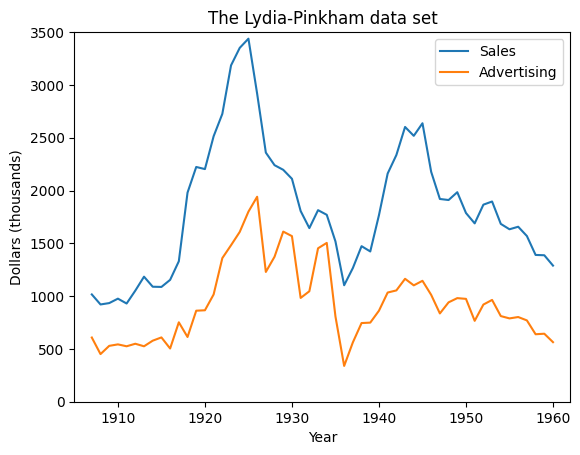

In [2]:
# Load the Lydia Pinkham data
df = pd.read_csv('../data/lydia_pinkham.csv')
y1 = df['Advertising'].values  # Advertising
y2 = df['Sales'].values         # Sales
time = df['Year'].values
noLags = 20

plt.figure()
plt.plot(time, y2, label='Sales')
plt.plot(time, y1, label='Advertising')
plt.xlabel('Year')
plt.ylabel('Dollars (thousands)')
plt.axis([1905, 1962, 0, 3500])
plt.legend()
plt.title('The Lydia-Pinkham data set')
plt.show()

## Should we transform the data?

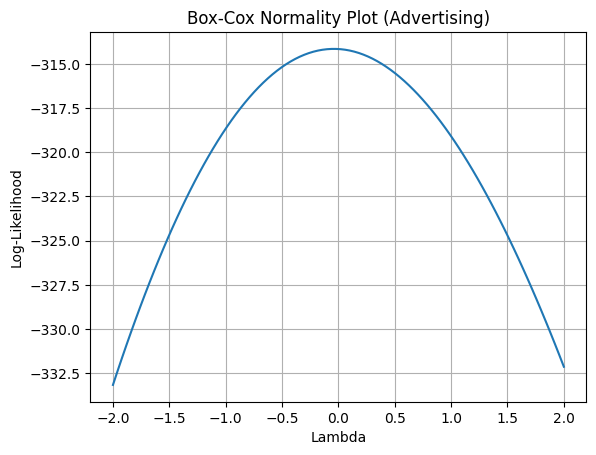

Max Lambda = -0.03992717309861356.
ln(y) could be an appropriate transformation.


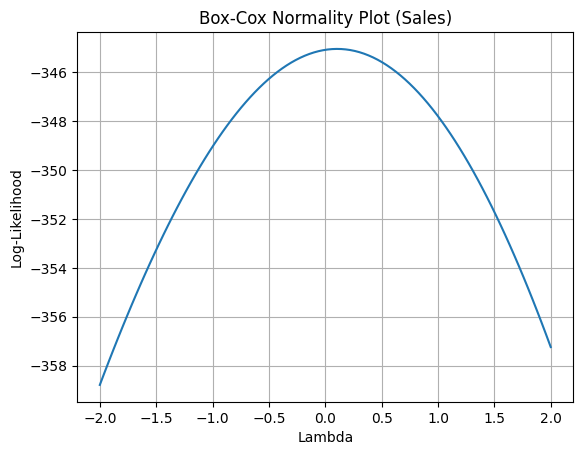

Max Lambda = 0.10527205685589552.
ln(y) could be an appropriate transformation.


In [3]:
lambda_max = box_cox(y1, titleStr='Advertising')
lambda_max = box_cox(y2, titleStr='Sales')

In [4]:
# Both indicate that a log-transform could be helpful
y1 = np.log(y1)
y2 = np.log(y2)

## Let's model the sales as input

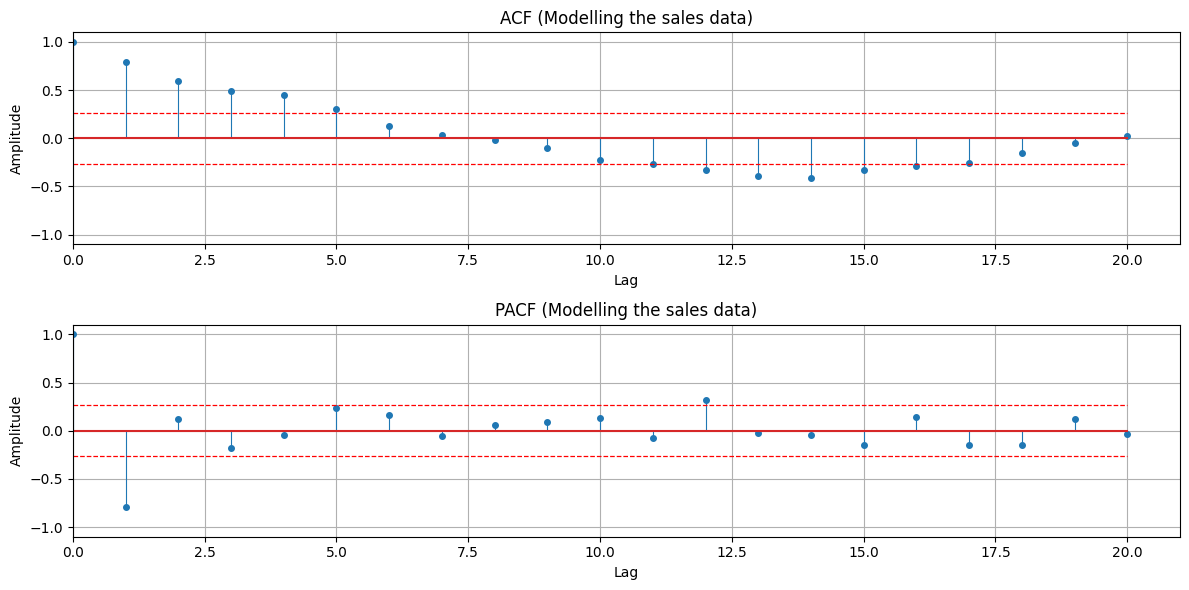

In [5]:
plotACFnPACF(y1, noLags, 'Modelling the sales data')

## Looks like it might need to be differentiated - let's try that

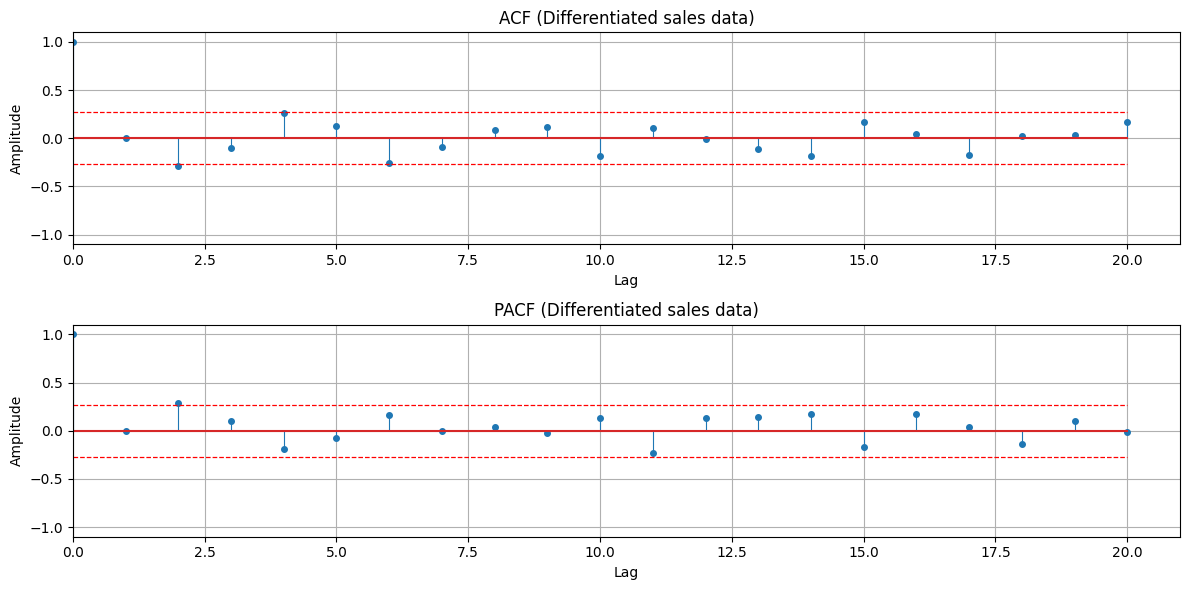

In [6]:
AS = np.array([1, -1])
y1_diff = lfilter(AS, 1, y1)
y1_diff = y1_diff[len(AS):]
rhoEst, phiEst = plotACFnPACF(y1_diff, noLags, 'Differentiated sales data', return_val=True)

## Seems that this was enough, the differentiated input is white

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 30.16 < 31.41)
  McLeod-Li test:        True (white if 19.40 < 31.41)
  Monti test:            True (white if 26.41 < 31.41)
  Sign change test:      True (white if 0.49 in [0.36,0.64])
The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


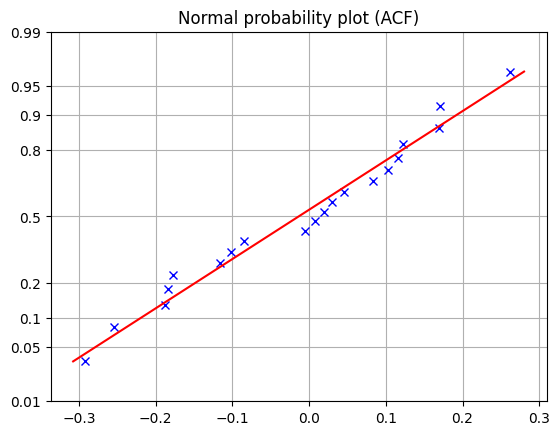

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


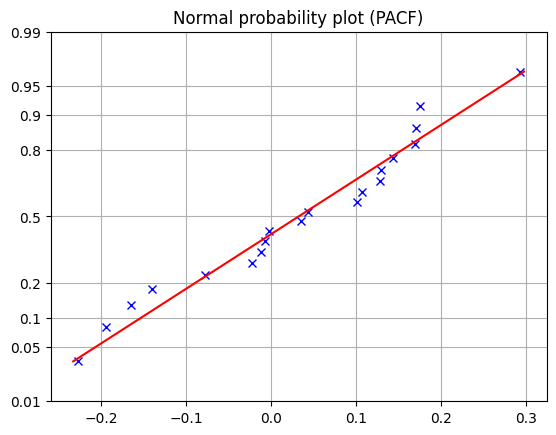

In [7]:
whiteness_test(y1_diff, K=noLags)
check_if_normal(rhoEst[1:], which_test='D')
normplot(rhoEst[1:], titleStr='ACF')
check_if_normal(phiEst[1:], which_test='D')
normplot(phiEst[1:], titleStr='PACF')

## Let's look at the cross correlation

Note that A3 is the differentiation, i.e., AS, and C3 = 1.

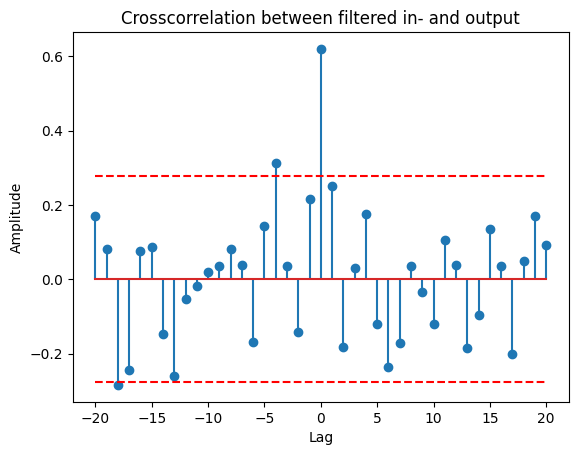

In [8]:
ey = lfilter(AS, 1, y2)
ey = ey[len(AS):]

lags, Cxy = xcorr(ey, y1_diff, maxlag=noLags, norm='coeff')

plt.figure()
plt.stem(lags, Cxy)
condInt = 2 * np.ones(len(lags)) / np.sqrt(len(ey))
plt.plot(lags, condInt, 'r--')
plt.plot(lags, -condInt, 'r--')
plt.xlabel('Lag')
plt.ylabel('Amplitude')
plt.title('Crosscorrelation between filtered in- and output')
plt.show()

## Form the BJ model

It seems we get away with just a scaling, b0.

Discrete-time BJ model: y(t) = B(z)x(t) + e(t)

B(z) = 1.1006(±0.0042)

Polynomial orders: nB = 0
Number of free coefficients: 1
Fit to estimation data (NRMSE): 39.13%
FPE : 0.046  MSE : 0.044
AIC : -13.14   BIC : -11.151



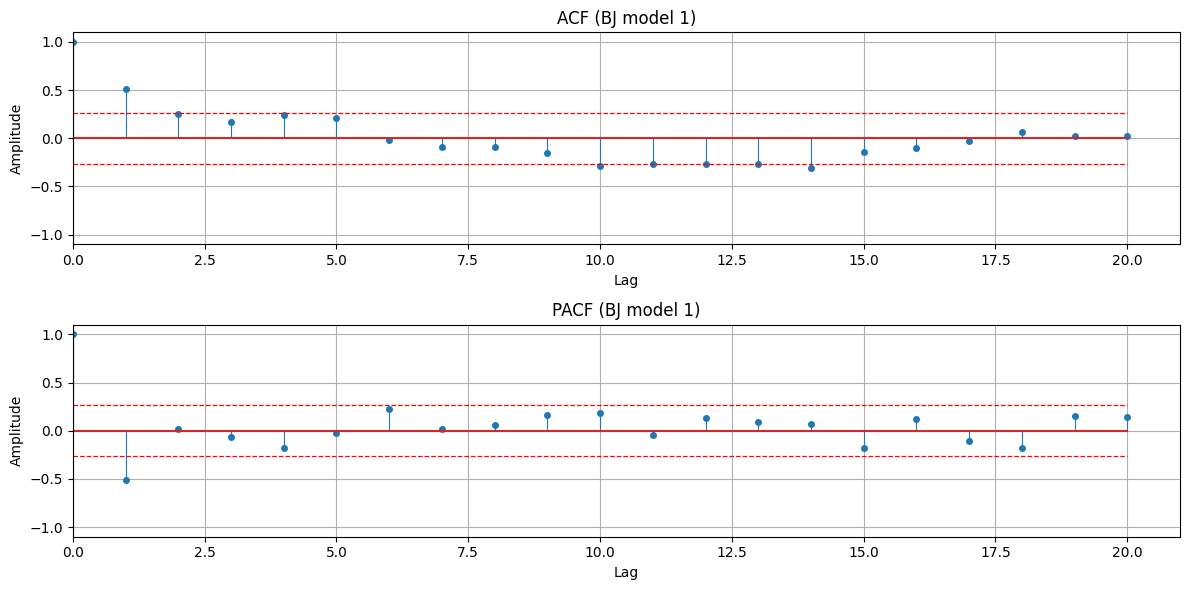

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 64.22 < 37.65)
  McLeod-Li test:        False (white if 43.06 < 37.65)
  Monti test:            False (white if 40.39 < 37.65)
  Sign change test:      False (white if 0.32 in [0.37,0.63])


In [9]:
estimateBJ(y2, y1, B=1, d=0, A2=[1], C1=[1], A1=[1], titleStr='BJ model 1', noLags=noLags)

## There is a dependence at lag 1 in the PACF, let's add that

Discrete-time BJ model: y(t) = B(z)x(t) + [1/D(z)]e(t)

B(z) = 1.0998(±0.0076)
D(z) = 1.0 - 0.5184(±0.1182)·z⁻¹

Polynomial orders: nB = 0    nD = 1
Number of free coefficients: 2
Fit to estimation data (NRMSE): 47.53%
FPE : 0.035  MSE : 0.033
AIC : -26.589   BIC : -22.648



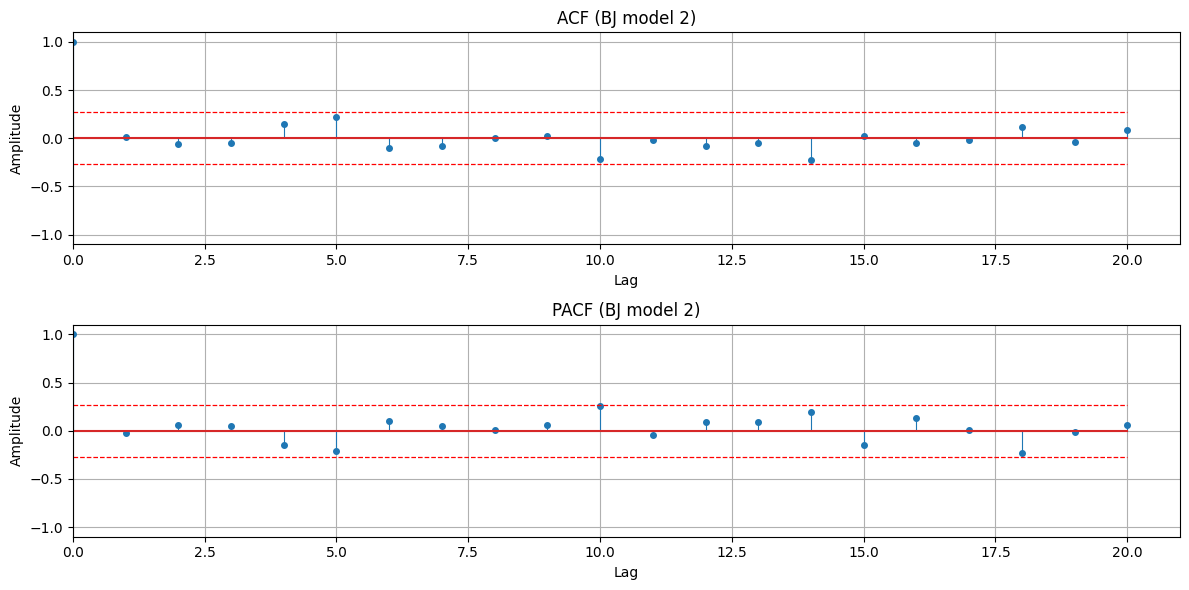

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 21.44 < 37.65)
  McLeod-Li test:        True (white if 23.95 < 37.65)
  Monti test:            True (white if 24.25 < 37.65)
  Sign change test:      True (white if 0.46 in [0.36,0.64])


In [10]:
foundModel = estimateBJ(y2, y1, B=1, d=0, A2=[1], C1=[1], A1=[1, 1], titleStr='BJ model 2', noLags=noLags)
ey = foundModel.resid

## That seems fairly white. Let's check

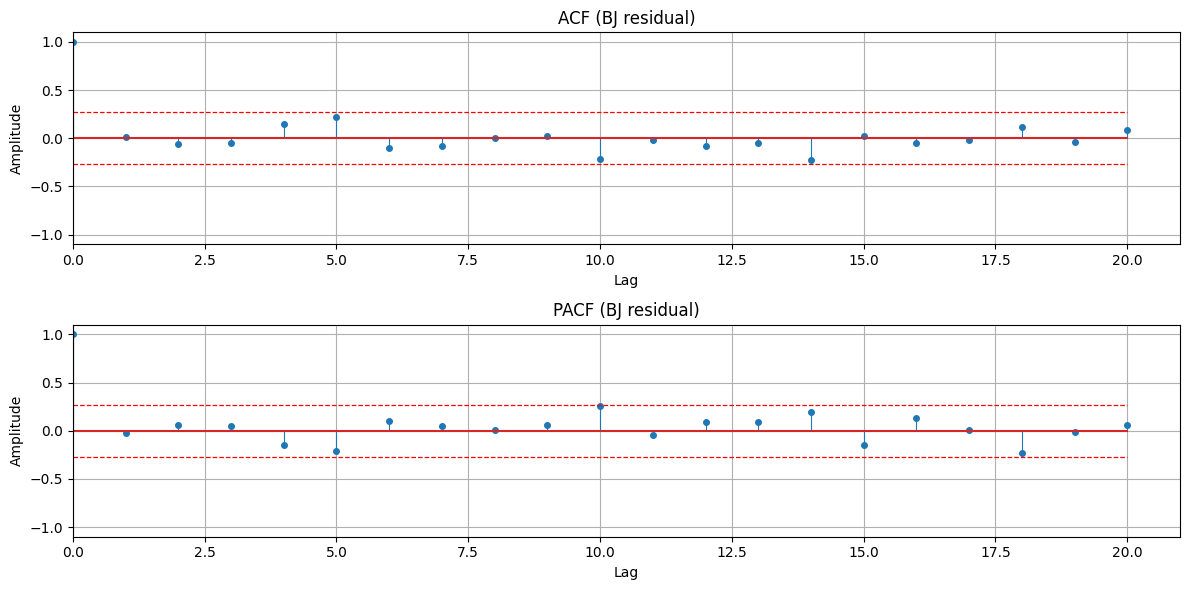

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


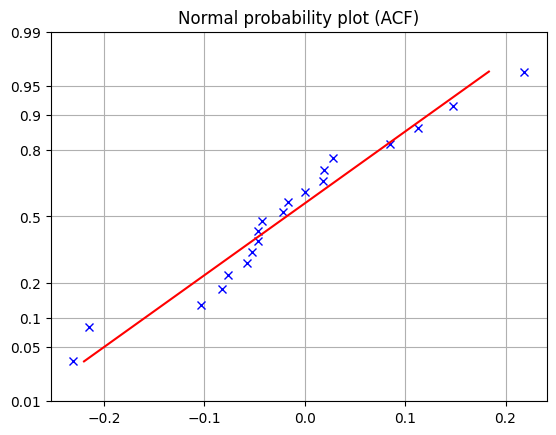

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


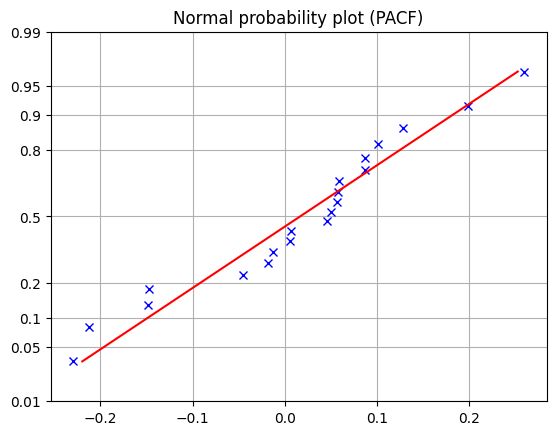

In [11]:
acfEst, pacfEst = plotACFnPACF(ey, noLags, 'BJ residual', return_val=True)
check_if_normal(acfEst[1:], which_test='D')
normplot(acfEst[1:], titleStr='ACF')
check_if_normal(pacfEst[1:], which_test='D')
normplot(pacfEst[1:], titleStr='PACF')

## Did we manage to extract all the information from the input?

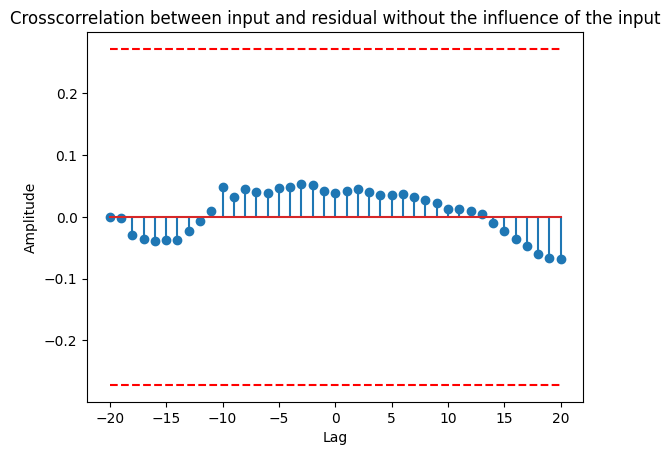

In [12]:
tilde_et = y2 - lfilter(foundModel.B, foundModel.F, y1)

# Note that we now have to remove samples from x as well
tilde_et = tilde_et[len(foundModel.B):]
filter_xt = y1[len(foundModel.B):]

lags, Cxy = xcorr(filter_xt, tilde_et, maxlag=noLags, norm='coeff')

plt.figure()
plt.stem(lags, Cxy)
condInt = 2 * np.ones(len(lags)) / np.sqrt(len(y1))
plt.plot(lags, condInt, 'r--')
plt.plot(lags, -condInt, 'r--')
plt.xlabel('Lag')
plt.ylabel('Amplitude')
plt.title('Crosscorrelation between input and residual without the influence of the input')
plt.show()